## Generalizing a Convolutional Network
In this problem, you will re-train a CNN using the MNIST data set and use it to classify your own hand-written digits. 

In [124]:
# %load ./include/header.py
import numpy as np
import matplotlib.pyplot as plt
import sys
from tqdm import trange,tqdm
sys.path.append('./include')
import ml4s
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('./include/notebook.mplstyle')
np.set_printoptions(linewidth=120)
ml4s._set_css_style('./include/bootstrap.css')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import datetime

### Part (a)
Write out the digits 0-9 in your own handwriting and import them as a testing data-set. You will need to pre-process them to ensure that they are in the MNIST format (i.e. 28 x 28 1-channel normalized grayscale images).

In [146]:
x_val=[]
y_val=[]
digits=[]
grid_size = 28
extent=[0.0,1.0,0.0,1.0]
X=np.meshgrid(np.linspace(extent[0],extent[1],grid_size),np.linspace(extent[2],extent[3],grid_size))
batch_size=grid_size**2
a=np.zeros([batch_size,2])
a[:,0]=X[0].flatten()
a[:,1]=X[1].flatten()

def target(x,y,data):
    num_pixels=data.shape[0]
    row=np.floor(y*num_pixels-1E-3).astype(int)
    col=np.floor(x*num_pixels-1E-3).astype(int)
    return data[row,col]

for k in range(10):
    image = plt.imread(f'{k}.PNG')[:,:,0]
    image = np.abs(1-image)
    y_val.append(k)
    result=np.zeros_like(X[0])
    for i in range(grid_size):
        for j in range(grid_size):
            x=X[0][i,j]
            y=X[1][i,j]
            result[i,j]=target(x,y,image)
    x_val.append(result)
    digits.append(result.flatten())

x_val=np.array(x_val)
x_val=x_val.reshape(10,28,28,1)
digits=np.array(digits)

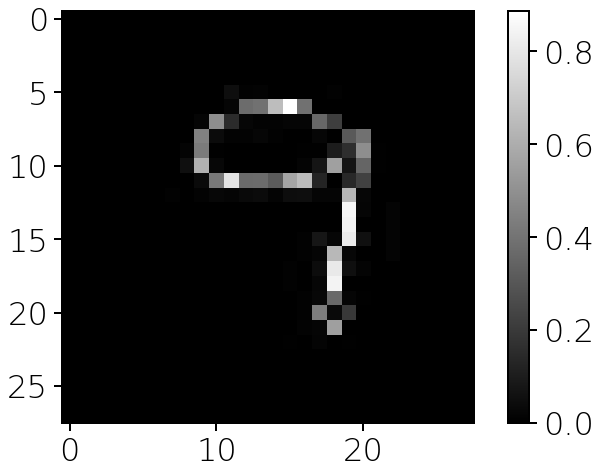

In [147]:
plt.imshow(x_val[9], cmap='gray')
plt.colorbar()

### Part (b)
Re-train the CNN we defined in lecture and check the accuracy on your handwritten digits. Include plots showing the soft-max probabilities and classification for each one. 

In [127]:
def plot_digit_array(x,y, show_prediction=False):
    '''Expects a list of digits (x) and associated labels (y)'''
    
    # determine the number of rows and columns of our image array
    num_digits = x.shape[0]
    num_cols = int(np.sqrt(num_digits))
    num_rows = num_digits//num_cols + 1

    fig,ax = plt.subplots(nrows=num_rows,ncols=num_cols,sharex=True,sharey=True,
                          figsize=(num_cols,num_rows))
    
    # plot all the numbers
    for i,cax in enumerate(ax.flatten()):
        if i < num_digits:
            cax.matshow(x[i].reshape(28,28), cmap='binary')
            cax.axis('off')
            if show_prediction:
                cax.text(0.99,0.99,f'{y[i]}',horizontalalignment='right',verticalalignment='top', 
                         transform=cax.transAxes, fontsize=8, color='r')
        else:
            cax.axis('off')

In [128]:
# load the data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# determine the properties
rows,cols = x_train[0].shape
num_classes = 10

x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

# use a built-in function to get 1-hot encoding
y_train_hot = keras.utils.to_categorical(y_train, num_classes)
y_test_hot = keras.utils.to_categorical(y_test, num_classes)

In [140]:
model = keras.Sequential(
[
    layers.Conv2D(input_shape=(rows,cols,1), kernel_size=(5, 5), filters=20,
                  activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(30, (6, 6), activation='relu'),
    layers.Dropout(0.5),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(30*4*4, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])
    
# compile 
model.compile(loss=keras.losses.categorical_crossentropy, optimizer='Adam', metrics=['accuracy'])

model.summary()


Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 28, 28, 20)        520       
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 14, 14, 20)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 9, 9, 30)          21630     
_________________________________________________________________
dropout_21 (Dropout)         (None, 9, 9, 30)          0         
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 4, 4, 30)          0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 480)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 480)             

In [145]:
batch_size = 128
epochs = 10

training = model.fit(x_train,y_train_hot, batch_size=batch_size, epochs=epochs,
                     verbose=1, validation_data=(x_test,y_test_hot))

Epoch 1/10
469/469 [==============================] - 53s 113ms/step - loss: 0.0305 - accuracy: 0.9904 - val_loss: 0.0314 - val_accuracy: 0.9910
Epoch 2/10
469/469 [==============================] - 53s 113ms/step - loss: 0.0276 - accuracy: 0.9911 - val_loss: 0.0253 - val_accuracy: 0.9927
Epoch 3/10
469/469 [==============================] - 53s 113ms/step - loss: 0.0258 - accuracy: 0.9924 - val_loss: 0.0235 - val_accuracy: 0.9936
Epoch 4/10
469/469 [==============================] - 53s 113ms/step - loss: 0.0246 - accuracy: 0.9920 - val_loss: 0.0212 - val_accuracy: 0.9933
Epoch 5/10
469/469 [==============================] - 53s 113ms/step - loss: 0.0239 - accuracy: 0.9924 - val_loss: 0.0233 - val_accuracy: 0.9923
Epoch 6/10
469/469 [==============================] - 53s 114ms/step - loss: 0.0251 - accuracy: 0.9920 - val_loss: 0.0211 - val_accuracy: 0.9936
Epoch 7/10
469/469 [==============================] - 53s 113ms/step - loss: 0.0219 - accuracy: 0.9933 - val_loss: 0.0208 - val_ac

In [148]:
guesses = model(x_val)
y_val_guess = np.argmax(guesses,axis=1)
mistakes = np.where(y_val_guess != y_val)[0]
print("Mistakes",mistakes)
predictions_prob_test = model(x_test)
predictions_test = np.argmax(predictions_prob_test,axis=1)
mistakes_test = np.where(predictions_test != y_test)[0]

Mistakes []


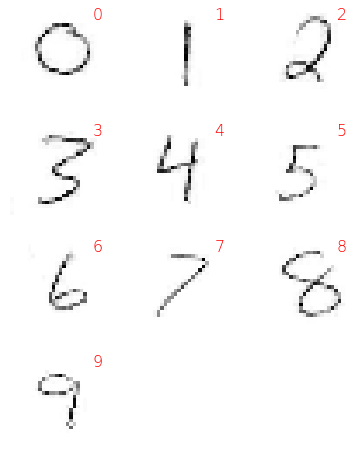

In [150]:
plot_digit_array(digits,np.array(y_val_guess),show_prediction=True)

### Part (c)
If you were able to achieve 100% success you are done! If not, explore hyperparameter adjustments to improve your accuracy.

My 9 didn't work, so I'm going to try to rotate it slightly to make it more vertical. Now It's working!